In [10]:
from os import path

import matplotlib.pyplot as plt
import numpy as np
import torch
from pandas import DataFrame
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from torch.nn import Linear
from torch.utils.data import DataLoader
from torchvision.datasets.folder import ImageFolder
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torchvision.transforms import Resize, CenterCrop, ToTensor, Compose, Normalize

from shared import BASE_DIR, CLASSES

training_device = "cuda" if (torch.cuda.is_available()) else "cpu"
print("using", training_device)

resnext_model = None

def get_resnext_model():
    global resnext_model

    if resnext_model is not None:
        return resnext_model

    checkpoint = torch.load("../checkpoint-model")

    resnext_model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
    resnext_model.fc = Linear(resnext_model.fc.in_features, len(CLASSES))
    resnext_model.load_state_dict(checkpoint["model_state_dict"])
    model = resnext_model.to(training_device)
    model.eval()

    return resnext_model


def resnext_stats():
    test_set = ImageFolder(path.join(BASE_DIR, "test"), transform=Compose([
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]))
    test_loader = DataLoader(test_set, batch_size=12, shuffle=True, num_workers=8)

    predictions = []
    corrects = []

    model = get_resnext_model()
    for inputs, labels in test_loader:
        output = model(inputs.to(training_device))
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        predictions.extend(output)

        labels = labels.data.cpu().numpy()
        corrects.extend(labels)

    cm = confusion_matrix(corrects, predictions, normalize="true")
    cm_df = DataFrame(cm, index=[i for i in CLASSES], columns=[i for i in CLASSES])

    plt.figure()
    heatmap(cm_df, annot=True)
    plt.savefig("resnext_confusion_matrix.png")

using cuda


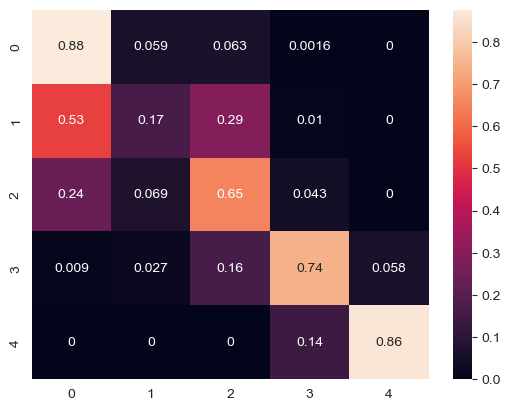

In [11]:
resnext_stats()